# Pochette d'album

### Installer la librairie requise

In [1]:
!pip install --quiet git+https://github.com/greentfrapp/lucent.git

     |████████████████████████████████| 204kB 10.7MB/s 
ERROR: kornia 0.4.0 has requirement torch<1.7.0,>=1.6.0, but you'll have torch 1.7.0+cu101 which is incompatible.
ERROR: pytest-mock 3.3.1 has requirement pytest>=5.0, but you'll have pytest 3.6.4 which is incompatible.


In [2]:
!git clone https://github.com/nathanhubens/MultimedIA.git

Cloning into 'MultimedIA'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 88 (delta 20), reused 24 (delta 10), pack-reused 52
Unpacking objects: 100% (88/88), done.


In [3]:
cd MultimedIA/Lesson\ 4

/content/MultimedIA/Lesson 4


### Importer les librairies

In [4]:
import torch
from PIL import Image
import numpy as np
import requests
from io import BytesIO

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1, util
from lucent.misc.io import show
from lucent.optvis.objectives import wrap_objective

from style_transfer import *

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Images

In [6]:
content_image = load("https://upload.wikimedia.org/wikipedia/en/6/6e/Pink_Floyd_-_Division_Bell.jpg")
style_image = load("https://images-na.ssl-images-amazon.com/images/I/71ClyL3iOxL._SY355_.jpg")


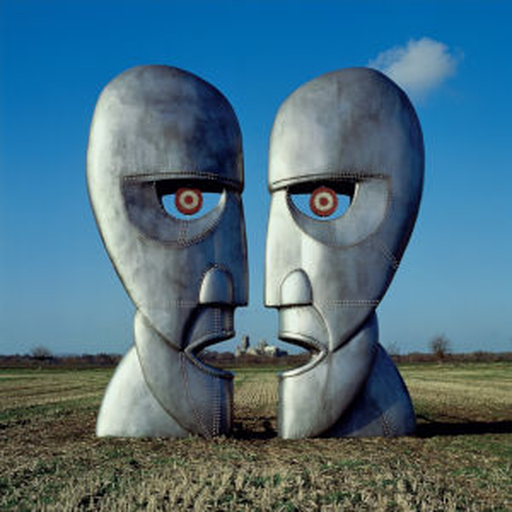


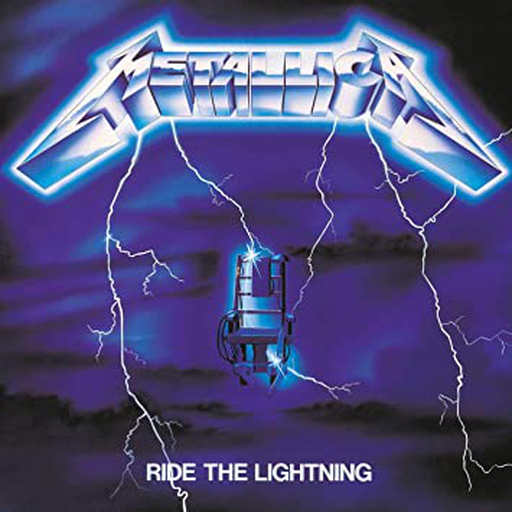

In [7]:
show(content_image)
show(style_image)

## Style Transfer Primer

In essence, we minimize two objectives.

1. A **style** objective that minimizes differences in non-spatial feature attributes between the generated image and a target style image - here we need to discourage spatial similarity and encourage non-spatial similarity
2. A **content** objective that minimizes differences in spatial attributes between the generated image and a target content image - here we care about the correct positions of buildings, people, objects etc.

In [8]:
model = inceptionv1(pretrained=True)
_ = model.to(device).eval()

Downloading: "https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth" to /root/.cache/torch/hub/checkpoints/inception5h.pth


In [9]:
util.get_model_layers(model)

['conv2d0_pre_relu_conv',
 'conv2d1_pre_relu_conv',
 'conv2d2_pre_relu_conv',
 'mixed3a_1x1_pre_relu_conv',
 'mixed3a_3x3_bottleneck_pre_relu_conv',
 'mixed3a_5x5_bottleneck_pre_relu_conv',
 'mixed3a_pool_reduce_pre_relu_conv',
 'mixed3a_3x3_pre_relu_conv',
 'mixed3a_5x5_pre_relu_conv',
 'mixed3b_1x1_pre_relu_conv',
 'mixed3b_3x3_bottleneck_pre_relu_conv',
 'mixed3b_5x5_bottleneck_pre_relu_conv',
 'mixed3b_pool_reduce_pre_relu_conv',
 'mixed3b_3x3_pre_relu_conv',
 'mixed3b_5x5_pre_relu_conv',
 'mixed4a_1x1_pre_relu_conv',
 'mixed4a_3x3_bottleneck_pre_relu_conv',
 'mixed4a_5x5_bottleneck_pre_relu_conv',
 'mixed4a_pool_reduce_pre_relu_conv',
 'mixed4a_3x3_pre_relu_conv',
 'mixed4a_5x5_pre_relu_conv',
 'mixed4b_1x1_pre_relu_conv',
 'mixed4b_3x3_bottleneck_pre_relu_conv',
 'mixed4b_5x5_bottleneck_pre_relu_conv',
 'mixed4b_pool_reduce_pre_relu_conv',
 'mixed4b_3x3_pre_relu_conv',
 'mixed4b_5x5_pre_relu_conv',
 'mixed4c_1x1_pre_relu_conv',
 'mixed4c_3x3_bottleneck_pre_relu_conv',
 'mixed4c_5

In [10]:
style_layers = [
  'conv2d2',
  'mixed3a',
  'mixed4a',
  'mixed4b',
  'mixed4c',
]

content_layers = [
  'mixed3b',
]

Check that the shape is what we expect!

In [11]:
assert np.allclose(list(style_transfer_param(content_image, style_image)[1]().shape), [3, 3, 512, 512])

/usr/local/lib/python3.6/dist-packages/lucent/optvis/param/spatial.py:57: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  image = torch.irfft(scaled_spectrum_t, 2, normalized=True, signal_sizes=(h, w))


Following the original Lucid style transfer notebook, we define a new objective with the `@wrap_objective` decorator.

The vanilla objective acts as a **content** objective.

To use it as a **style** objective, we pass a `transform_f` parameter that transforms input images into Gram matrix representations, which removes spatial information.

Following the original "Image Style Transfer Using Convolutional Neural Networks" [paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) by Gatys, Ecker and Bethge in CVPR2015, we use the Gram matrix to represent the images in a "spatially-invariant" manner. The Gram matrix essentially represents correlations between features and is a $N \times N$ matrix where $N$ is the number of features or channels.

Finally, we put everything together!

There is some tuning involved to balance between the content objective and the style objective using the `content_weight` and `style_weight` parameters.

100%|██████████| 512/512 [01:15<00:00,  6.75it/s]



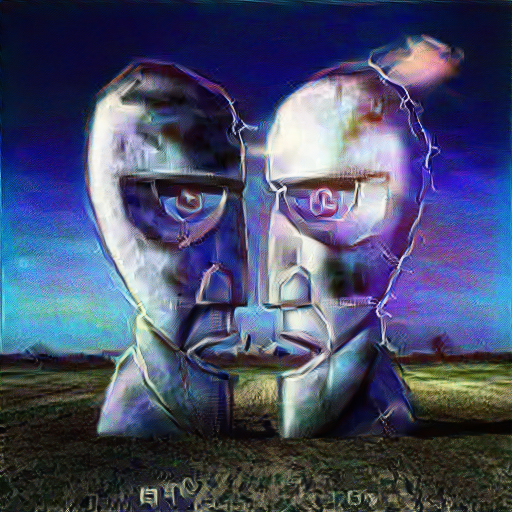
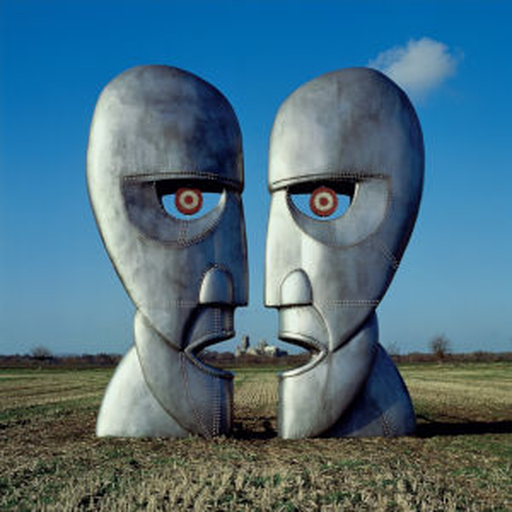
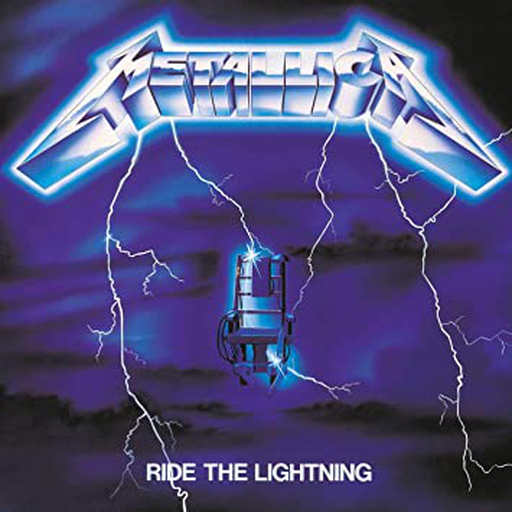

In [12]:
style_transfer(content_image, style_image, model, content_layers, style_layers, 500, 1)

## Try yourselves ! 

In [13]:
content_image = load("https://scontent-cdt1-1.xx.fbcdn.net/v/t1.0-9/30265296_1331753850259394_3174631588008820736_o.jpg?_nc_cat=110&ccb=2&_nc_sid=174925&_nc_ohc=dmVQabLHxeQAX9UWojn&_nc_ht=scontent-cdt1-1.xx&oh=b2cdd035c9e064239e5fe00e7a8f9dfc&oe=5FBB685F")
style_image = load("https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project.jpg/1200px-Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project.jpg")


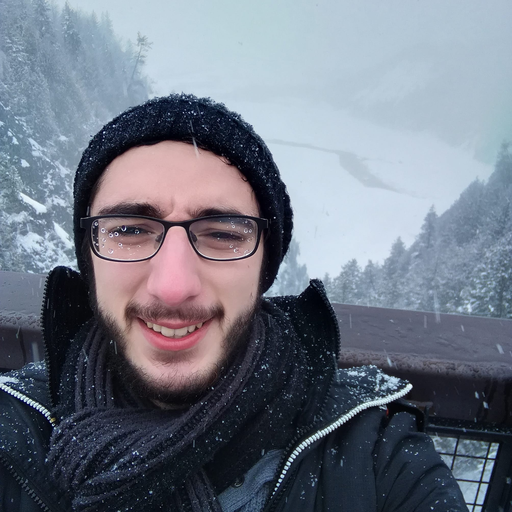


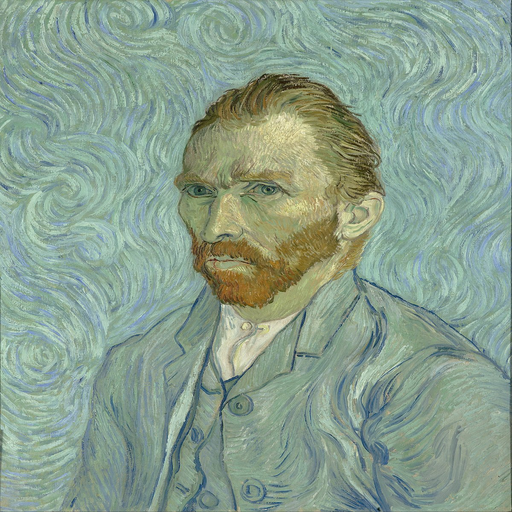

In [14]:
show(content_image)
show(style_image)

In [22]:
style_layers = [
  'conv2d2',
  'mixed3a',
  'mixed4a',
  'mixed4b',
  'mixed4c',
]

content_layers = [
  'mixed5a',
]

In [23]:
style_transfer(content_image, style_image, model, content_layers, style_layers, 500, 1)

Output hidden; open in https://colab.research.google.com to view.

100%|██████████| 512/512 [01:18<00:00,  6.54it/s]



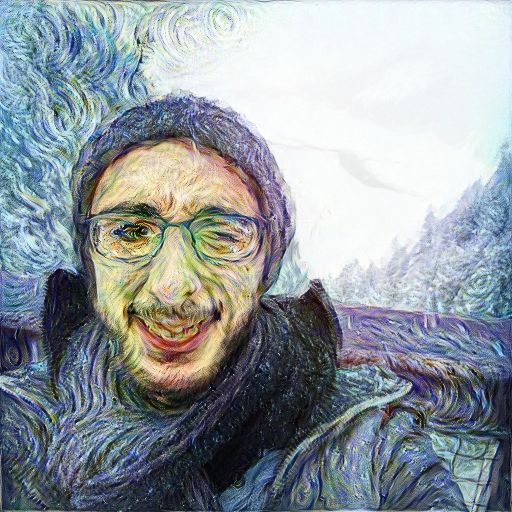
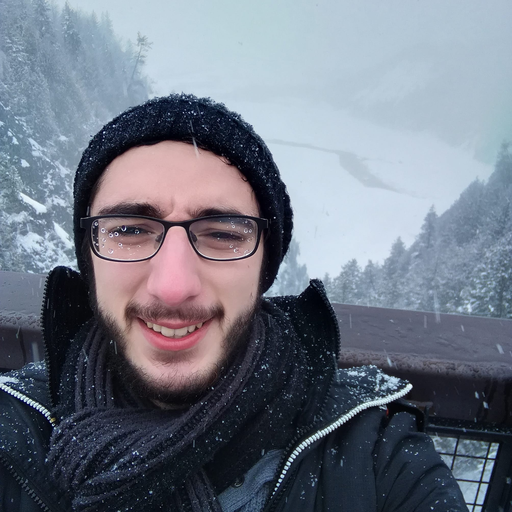
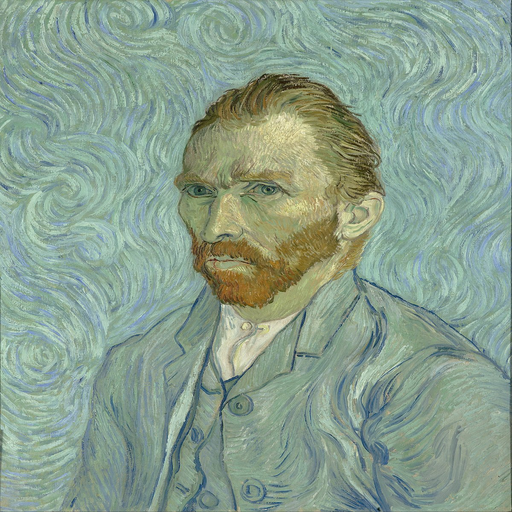

In [19]:
style_transfer(content_image, style_image, model, content_layers, style_layers, 500, 1)